<h1>Minimum Distance Analysis for Field Emission from a Ring-Shaped Emitter

<h3>Import

In [6]:
# Math
import numpy as np
import math as m
# Data
import pandas as pd
# Plotting
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns
sns.set_theme()

<h4>Functions

In [7]:
def ave_min(data):
    '''Find the average minimum angle from each point to its nearest neighbour'''
    # Calculate the distance between each point
    ave_min_dist = np.mean(data['min_dist'])
    std_min_dist = np.std(data['min_dist'])
    return ave_min_dist, std_min_dist
    

<h4>Fetch data

In [ ]:
max_height = 1.5e-9

simul_param = {
    # 100: {'time_start': 2500, 'time_end': 4000, 'time_step': 50, 'd_min': 1e-9, 'd_max': 10e-9, 'E0': 0, 'E': 0, 'distance': 1000e-9, 'ave_min_dist': 0},
    7000: {'time_start': 200, 'time_end': 1000, 'time_step': 25, 'd_min': 0e-9, 'd_max': max_height, 'distance': 1000e-9},
    9000: {'time_start': 200, 'time_end': 1000, 'time_step': 25, 'd_min': 0e-9, 'd_max': max_height, 'distance': 1000e-9},
    10000: {'time_start': 150, 'time_end': 1000, 'time_step': 25, 'd_min': 0e-9, 'd_max': max_height, 'distance': 1000e-9},
    11000: {'time_start': 200, 'time_end': 1000, 'time_step': 25, 'd_min': 0e-9, 'd_max': max_height, 'distance': 1000e-9},
}

simul_data = {'E0': [], 'E': [], 'dE': [], 'd': [], 'd_th': []}

In [9]:
epsilon_0 = 8.854187817e-12
q = 1.60217662e-19

elecbase = f'/out/elec-'
elec_dt_abs_type = np.dtype([('x', np.float64), ('y', np.float64), ('z', np.float64), ('min_dist', np.float64)])

fieldbase = '/out/field-'
field_dt_abs_type = np.dtype([('x', np.float64), ('y', np.float64), ('z', np.float64), ('field', np.float64)])

# fig = plt.figure(figsize=(10, 8))
for voltage,simulation in simul_param.items():

    # Get field data
    field_filename = f'./V{voltage}/out/field.dt'
    field_data = pd.read_csv(field_filename, sep='   ', header=None, names=['step', 'fx', 'fy', 'fz', 'a','b','c','d'])

    time_steps = np.arange(simulation['time_start'], simulation['time_end']+1, simulation['time_step'], dtype=int)
    for time_step in time_steps:

        # Get distance data
        elec_filename = f'./V{voltage}{elecbase}{time_step}.bin'
        data_mem_abs = np.memmap(elec_filename, dtype=elec_dt_abs_type, mode='r', order='F')
        elec_data = pd.DataFrame.from_records(data=data_mem_abs, columns=data_mem_abs.dtype.names)
        elec_data = elec_data[(elec_data['z'] >= simulation['d_min']) & (elec_data['z'] <= simulation['d_max'])]

        # Field calculations
        E = field_data[field_data['step'] == time_step]['fz'].values[0]  # Get the field at the current time step
        E0 = voltage/simulation['distance']

        # plt.plot(E0,E,'o')

        # Distance calculations
        d_th = m.sqrt(q*simulation['distance']/(m.pi*epsilon_0*voltage))
        # d_th = m.sqrt(q/(m.pi*epsilon_0*E))

        # Store data
        for i in range(len(elec_data)):
            simul_data['E0'].append(E0)
            simul_data['E'].append(E)
            simul_data['dE'].append(E0 - E)
            simul_data['d'].append(elec_data.iloc[i]['min_dist'])
            simul_data['d_th'].append(d_th)

# plt.show()
# Change to dataframe
dist_data = pd.DataFrame.from_dict(simul_data)

/tmp/ipykernel_49994/1583449650.py:15: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  field_data = pd.read_csv(field_filename, sep='   ', header=None, names=['step', 'fx', 'fy', 'fz', 'a','b','c','d'])
/tmp/ipykernel_49994/1583449650.py:15: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  field_data = pd.read_csv(field_filename, sep='   ', header=None, names=['step', 'fx', 'fy', 'fz', 'a','b','c','d'])
/tmp/ipykernel_49994/1583449650.py:15: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted

<h4>Minimum distance as a function of field

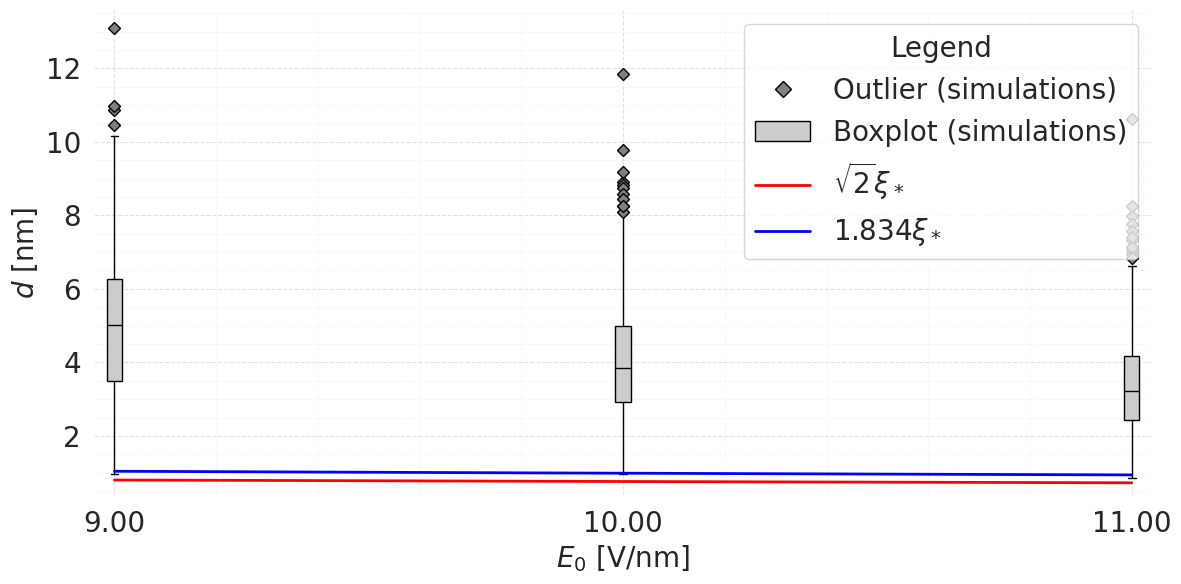

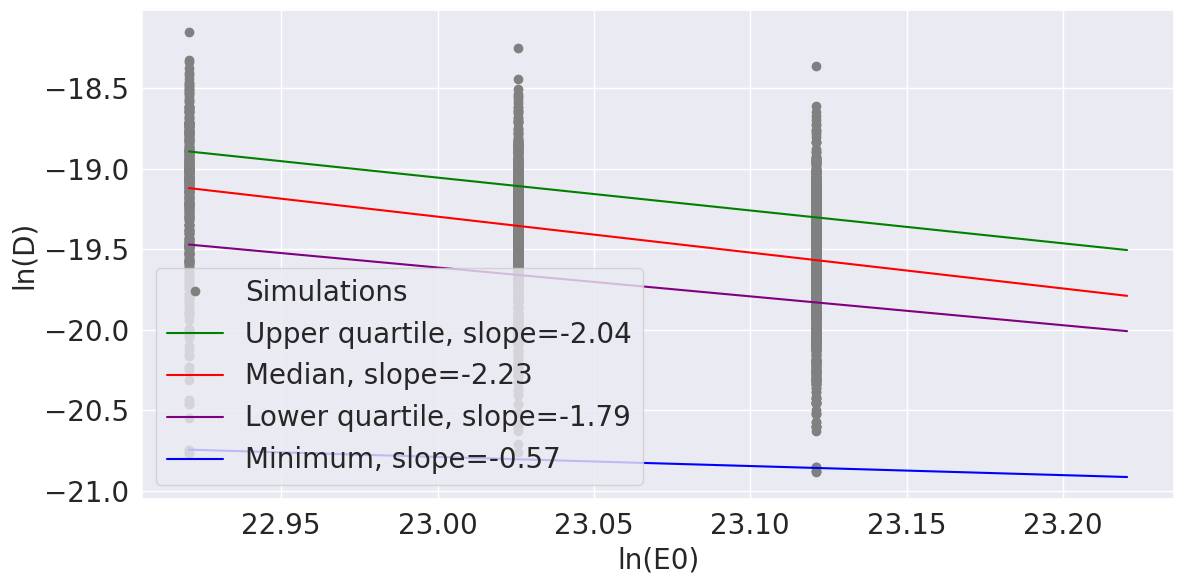

In [10]:
# --------------------------------------------------------------------
# Imports
# --------------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math as m
from matplotlib.lines  import Line2D
from matplotlib.patches import Patch
import matplotlib.ticker as mtick
from scipy.constants    import epsilon_0, e as q

# --------------------------------------------------------------------
# Data (your DataFrame is already called dist_data)
# --------------------------------------------------------------------
field = 'E0'            # unchanged

# global font size
fontz = 20

# --------------------------------------------------------------------
# --- FIRST FIGURE ----------------------------------------------------
# --------------------------------------------------------------------
# 1) theoretical curves
field_vector = np.linspace(dist_data[field].min(),
                           dist_data[field].max(), 300)  # V/m
xi_data      = np.sqrt(q / (2 * m.pi * epsilon_0 * field_vector))

# 2) real x-positions for the boxes
unique_fields = np.sort(dist_data[field].unique())       # V/m
x_pos         = unique_fields * 1e-9                     # V/nm

# y-data per box (nm)
box_data = [(dist_data.loc[dist_data[field] == E, 'd'] * 1e9).to_numpy()
            for E in unique_fields]

# 3) plot
fig, ax = plt.subplots(figsize=(12, 6))

# --- box-whisker ---
ax.boxplot(
    box_data,
    positions      = x_pos,
    widths         = 0.03,
    patch_artist   = True,
    boxprops       = dict(facecolor='0.8', edgecolor='black'),
    medianprops    = dict(color='black'),
    flierprops     = dict(marker='D',
                          markerfacecolor='grey',
                          markeredgecolor='black')
)

# --- theoretical curves ---
red_line  , = ax.plot(field_vector*1e-9,  np.sqrt(2)*xi_data*1e9,
                      color='red',  linewidth=2, label=r'$\sqrt{2}\xi_*$')
blue_line , = ax.plot(field_vector*1e-9,  1.834*xi_data*1e9,
                      color='blue', linewidth=2, label=r'$1.834\xi_*$')

# --------------------------------------------------------------------
# axis limits (same as before)
pad   = 0.04                                   # V/nm
y_min = (dist_data['d']*1e9).min()
y_max = (dist_data['d']*1e9).max()
ax.set_xlim(x_pos.min() - pad, x_pos.max() + pad)
ax.set_ylim(y_min - 0.5,      y_max + 0.5)

# --------------------------------------------------------------------
# labels, ticks, grid
ax.set_xlabel(r'$E_0$ [V/nm]', fontsize=fontz)
ax.set_ylabel(r'$d$ [nm]',          fontsize=fontz)
ax.set_xticks(x_pos)
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
ax.tick_params(axis='both', labelsize=fontz)
ax.grid(axis='x', linestyle='--', alpha=0.15)

# --------------------------------------------------------------------
# legend – now includes red & blue lines, moved to upper-right
diamond_handle   = Line2D([0], [0], marker='D', color='black',
                          markerfacecolor='grey', markersize=8,
                          linestyle='None', label='Outlier (simulations)')
rectangle_handle = Patch(facecolor='0.8', edgecolor='black',
                         label='Boxplot (simulations)')

fig.tight_layout()
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
leg = ax.legend(handles=[diamond_handle, rectangle_handle,
                         red_line, blue_line],
                title='Legend',
                loc='upper right',
                fontsize=fontz,
                title_fontsize=fontz)

leg.get_frame().set_facecolor('white')  
ax.grid(True, which='both', linestyle='--', alpha=0.3)   # light dashed grid on x & y# ── after you have defined all ticks but BEFORE plt.show() ────────────
ax.set_axisbelow(True)          # draw grid under every artist
ax.minorticks_on()              # so "which='both'" has something to show

# major grid (dashed), minor grid (dotted)
ax.grid(which='major', axis='both',
        linestyle='--', linewidth=0.8,
        color='lightgrey', alpha=0.7)

ax.grid(which='minor', axis='both',
        linestyle=':',  linewidth=0.5,
        color='lightgrey', alpha=0.5)
plt.show()

# --------------------------------------------------------------------
# --- SECOND FIGURE (log–log fits)  ----------------------------------
# --------------------------------------------------------------------
logE = np.log(dist_data[field])
logD = np.log(dist_data['d'])

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(logE, logD, 'o', label='Simulations', color='grey')

logE_fit_q = np.arange(logE.min(), logE.max() + 0.1, 0.1)
quartiles  = [0.75, 0.50, 0.25, 0.0]
colors     = ['green', 'red', 'purple', 'blue']
labels     = {0.75: 'Upper quartile',
              0.50: 'Median',
              0.25: 'Lower quartile',
              0.00: 'Minimum'}

for q, c in zip(quartiles, colors):
    tmp = (dist_data.groupby(field, as_index=False)
                      .quantile(q=q) if q else
           dist_data.groupby(field, as_index=False).min())

    slope, intercept = np.polyfit(np.log(tmp[field]), np.log(tmp['d']), 1)
    ax.plot(logE_fit_q, slope*logE_fit_q + intercept,
            color=c, label=f'{labels[q]}, slope={slope:.2f}')

ax.set_xlabel(f'ln({field})', fontsize=fontz)
ax.set_ylabel('ln(D)',        fontsize=fontz)
ax.tick_params(axis='both', labelsize=fontz)
ax.legend(fontsize=fontz, title_fontsize=fontz)
fig.tight_layout()
plt.show()


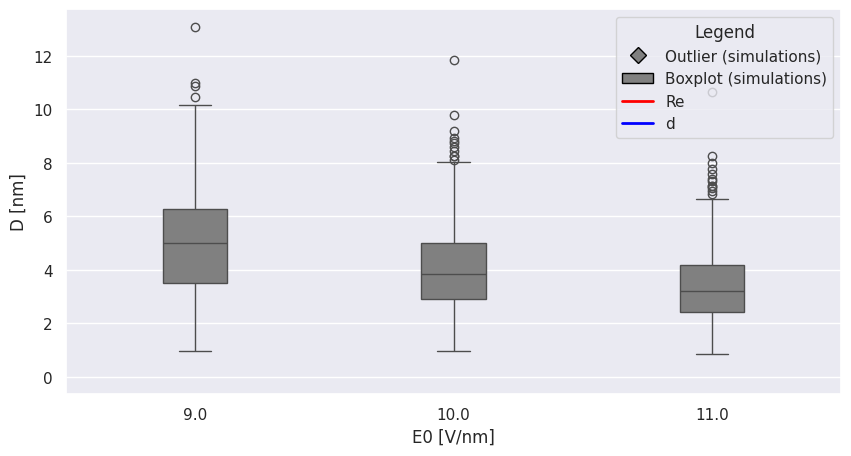

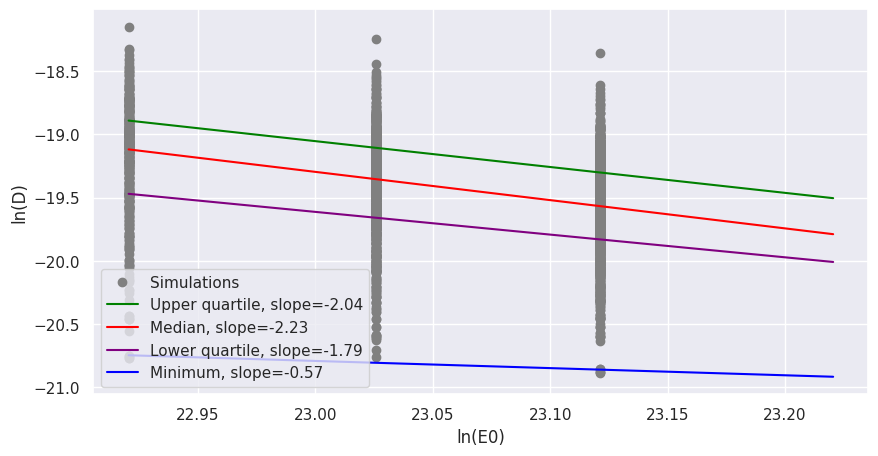

In [11]:
field = 'E0'

fig, ax = plt.subplots(figsize=(10,5))
field_vector = np.linspace(min(dist_data[field]), max(dist_data[field]), 100)
xi_data = [m.sqrt(q/(2*m.pi*epsilon_0*E)) for E in field_vector]
ax.plot(field_vector*1e-9, m.sqrt(2)*np.array(xi_data)*1e9, color='red')
ax.plot(field_vector*1e-9, 1.834*np.array(xi_data)*1e9, color='blue')
sns.boxplot(data=dist_data, x=round(dist_data[field]*1e-9,2), y=dist_data['d']*1e9, ax=ax, showfliers=True, color='grey', width=0.25) 

# sns.stripplot(data=dist_data, x=round(dist_data[field]*1e-9,2), y=dist_data['d_th']*1e9, ax=ax, color='red', size=1)
# plt.xlim(-0.5,len(simul_param)-0.5)
# plt.ylim(2,12.5)
plt.xlabel(f'{field} [V/nm]')
plt.ylabel('D [nm]')
diamond_handle = Line2D([0], [0],
                    marker='D',
                    color='black',
                    markerfacecolor='grey',
                    markersize=8,
                    linestyle='None',
                    label='Outlier (simulations)')

rectangle_handle = Patch(facecolor='grey',
                   edgecolor='black',
                   label='Boxplot (simulations)')
line_handle1    = Line2D([0], [0], 
                    color='red',
                    linestyle='-',
                    linewidth=2,
                    label='Re')
line_handle2    = Line2D([0], [0], 
                    color='blue',
                    linestyle='-',
                    linewidth=2,
                    label='d')

ax.legend(handles=[diamond_handle,rectangle_handle, line_handle1, line_handle2],
          title='Legend')
plt.show()



# Log-transform
logE = np.log(dist_data[field])
logD = np.log(dist_data['d'])

# Linear fit
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(logE, logD, 'o', label='Simulations', color='grey')

logE_fit_q = np.arange(min(logE), max(logE)+0.1, 0.1)

quartiles = [0.75, 0.50, 0.25, 0.0]
colors = ['green', 'red', 'purple', 'blue']

for i,q in enumerate(quartiles):
    # Find the quartile
    if (quartiles[i] == 0.0):
        temp_data = dist_data.groupby(by=field, as_index=False).min()
    else:
        temp_data = dist_data.groupby(by=field, as_index=False).quantile(q=q)

    # for e0 in temp_data[field]:
    #     print(f'E0: {e0:.2f} V/nm')
    #     print(f'nr of points: {len(dist_data[dist_data[field] == e0])}')

    
    # Fit the data
    logE_q = np.log(temp_data[field])
    logD_q = np.log(temp_data['d'])
    
    # Linear fit
    slope, intercept = np.polyfit(logE_q, logD_q, 1)
    logD_fit_q = slope*logE_fit_q + intercept

    # Plot the data
    if (quartiles[i] == 0.0):
        label = 'Minimum'
    elif (quartiles[i] == 0.25):
        label = 'Lower quartile'
    elif (quartiles[i] == 0.50):
        label = 'Median'
    else:
        label = 'Upper quartile'

    ax.plot(logE_fit_q, logD_fit_q, label=f'{label}, slope={slope:.2f}', color=colors[i])
ax.set_xlabel(f'ln({field})')
ax.set_ylabel('ln(D)')
ax.legend()
plt.show()

<h3>Distribution plot

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# --- choose how many bins you want per histogram ---
N_BINS = 30                       # tweak as you like

# loop over each distinct electric-field amplitude
for e0_val, grp in dist_data.groupby('E0'):
    plt.figure(figsize=(6, 4))                     # one new figure per E0
    # plt.hist(grp['d_th'], bins=N_BINS, alpha=0.75, edgecolor='black')
    
    # optional: overlay a smoothed curve
    try:
        from scipy.stats import gaussian_kde
        xs = np.linspace(grp['d'].min(), grp['d'].max(), 500)
        kde = gaussian_kde(grp['d'])
        # plt.plot(xs, kde(xs) * len(grp['d']) * (xs[1]-xs[0]), lw=2)
        print(len(grp))
        plt.plot(xs,kde(xs)/sum(grp),lw=2)
    except ImportError:
        pass  # SciPy not installed – just skip the KDE
    # plt.plot(grp['d_th'], np.zeros_like(grp['d_th']), 'o', color='red', markersize=2, alpha=0.5)
    plt.title(f'Distribution of $d_{{\\mathrm{{th}}}}$  (E₀ = {e0_val:.3e} V m⁻¹)')
    plt.xlabel(r'$d_{\mathrm{th}}$  (m)')
    plt.ylabel('Count')
    plt.xlim(0, 9.0e-9)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()

plt.show()


374


TypeError: unsupported operand type(s) for +: 'int' and 'str'

<Figure size 600x400 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- choose how many bins you want per histogram ---
N_BINS = 30                       # tweak as you like

dist_dict = {2.00e8:[], 6.00e8:[], 10.00e8:[]}

# loop over each distinct electric-field amplitude
for i, e0_val in enumerate(simul_data['E0']):
    if e0_val in dist_dict.keys():
        dist_dict[e0_val].append(simul_data['d'][i])

plt.figure(figsize=(6, 4))                     # one new figure per E0

from scipy.stats import gaussian_kde

for e0_val, grp in dist_dict.items():
    xs = np.linspace(min(grp), max(grp), 500)
    kde = gaussian_kde(grp)
    print(len(grp))
    plt.plot(xs*1e9,kde(xs)/max(kde(xs)),label=f'E₀ = {e0_val*1.0e-9:.3} V/nm', lw=2)

# plt.plot(grp['d_th'], np.zeros_like(grp['d_th']), 'o', color='red', markersize=2, alpha=0.5)
# plt.title(f'Distribution of $d_{{\\mathrm{{th}}}}$  (E₀ = {(e0_val*1.0e-9):f2} V/nm)')
plt.xlabel('d [nm]')
plt.ylabel('Count')
plt.xlim(2, 11.0)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
# top left
plt.legend(loc='upper right')

plt.show()
